In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import datetime

df = pd.read_csv("test(in).csv")

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df.head()


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


In [7]:
# Combine subject and body for analysis
df['text'] = df['Subject'].fillna('') + ' ' + df['body'].fillna('')

# Function to get sentiment polarity and label
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling
df['sentiment'] = df['text'].apply(get_sentiment)
df[['text', 'sentiment']].head()


,text,sentiment
0,EnronOptions Update! EnronOptions Announcement...,Positive
1,"(No Subject) Marc,\n\nUnfortunately, today is ...",Neutral
2,Phone Screen Interview - Shannon L. Burnham W...,Neutral
3,RE: My new work email we were thinking papasit...,Neutral
4,Bet Since you never gave me the $20 for the la...,Neutral


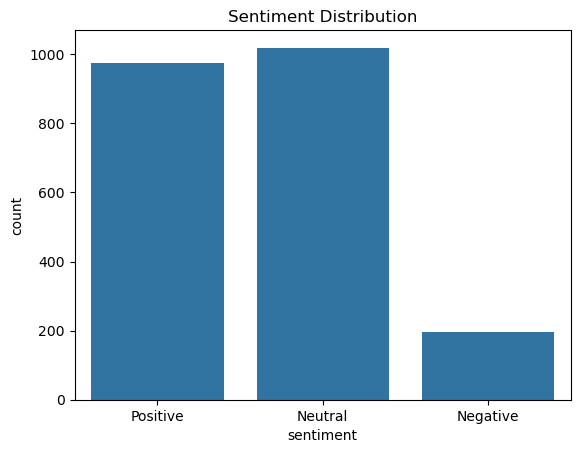

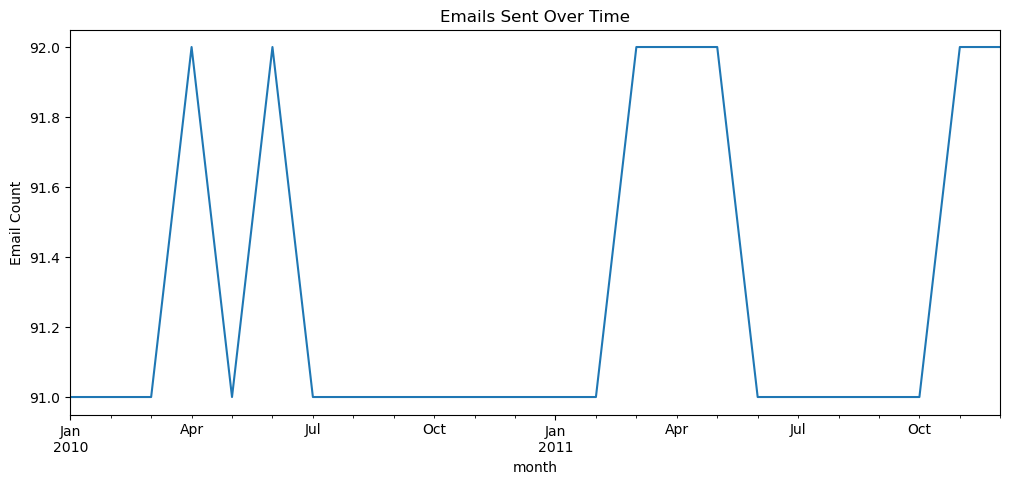

In [8]:
# Sentiment distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")
plt.show()

# Emails per month
df['month'] = df['date'].dt.to_period('M')
monthly_counts = df.groupby('month').size()

monthly_counts.plot(kind='line', figsize=(12,5), title="Emails Sent Over Time")
plt.ylabel("Email Count")
plt.show()


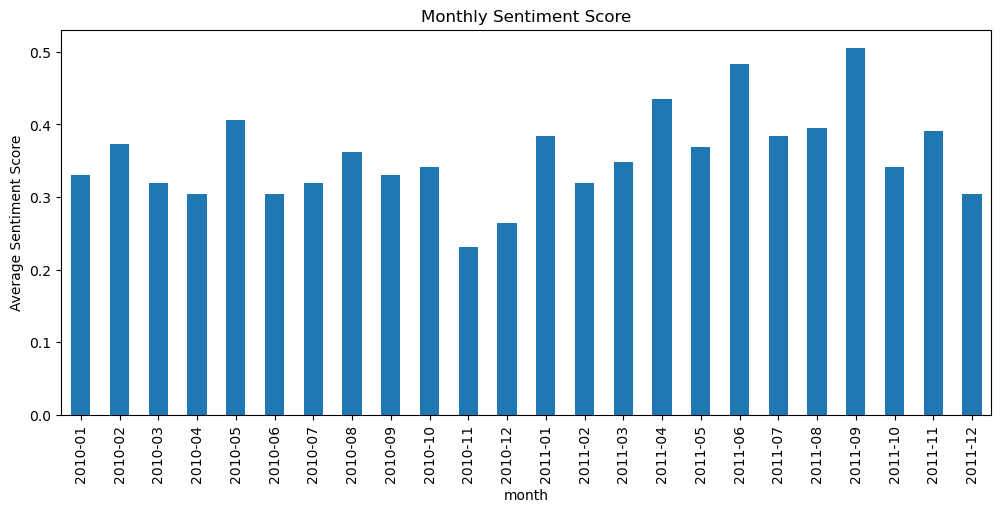

In [9]:
# Assign sentiment scores: +1 (Positive), 0 (Neutral), -1 (Negative)
score_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
df['sentiment_score'] = df['sentiment'].map(score_map)

# Group by month
monthly_sentiment = df.groupby('month')['sentiment_score'].mean()

monthly_sentiment.plot(kind='bar', figsize=(12,5), title="Monthly Sentiment Score")
plt.ylabel("Average Sentiment Score")
plt.show()


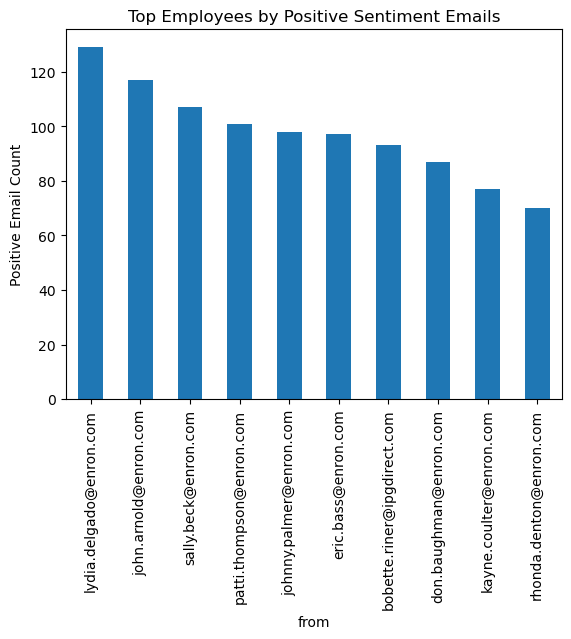

In [10]:
employee_scores = df[df['sentiment'] == 'Positive'].groupby('from').size().sort_values(ascending=False)

# Top 10 employees
employee_scores.head(10).plot(kind='bar', title="Top Employees by Positive Sentiment Emails")
plt.ylabel("Positive Email Count")
plt.show()


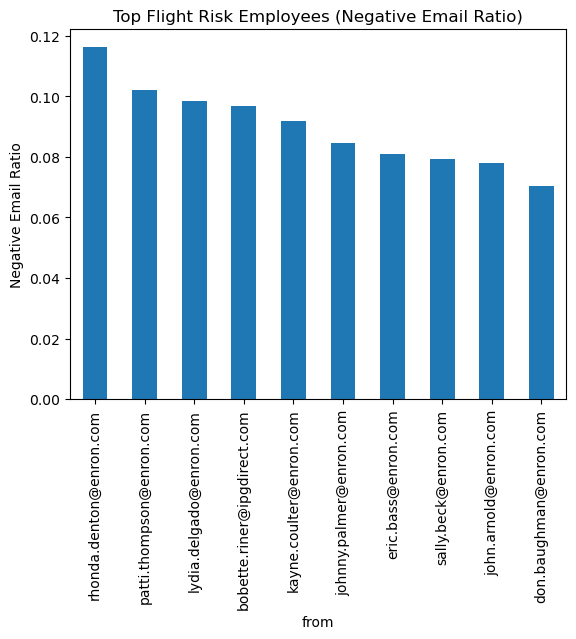

In [11]:
# Count of negative emails per employee
negative_counts = df[df['sentiment'] == 'Negative'].groupby('from').size()
# Normalize by total email
total_counts = df.groupby('from').size()
risk_ratio = (negative_counts / total_counts).fillna(0).sort_values(ascending=False)

# High risk employees
risk_ratio.head(10).plot(kind='bar', title="Top Flight Risk Employees (Negative Email Ratio)")
plt.ylabel("Negative Email Ratio")
plt.show()


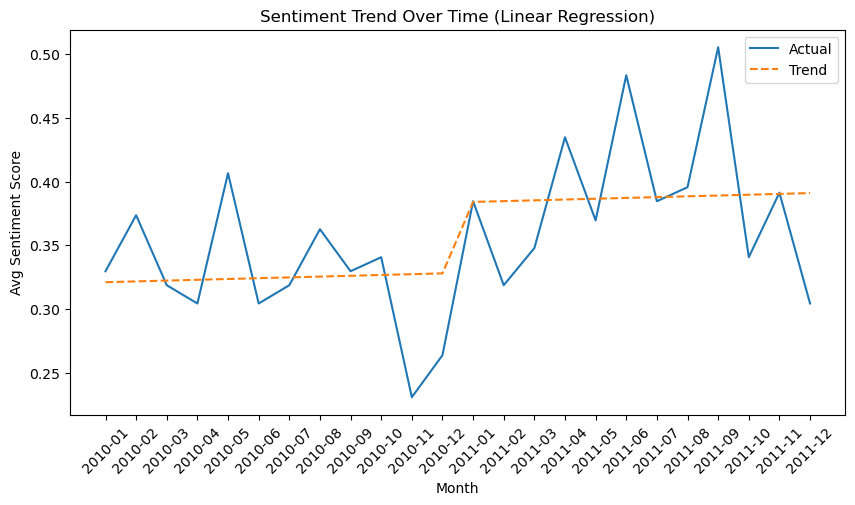

In [12]:
# Reset index for regression
trend_df = monthly_sentiment.reset_index()
trend_df['month_num'] = trend_df['month'].astype(str).apply(lambda x: int(x.replace('-', '')))

# Linear Regression
X = trend_df[['month_num']]
y = trend_df['sentiment_score']
model = LinearRegression()
model.fit(X, y)

# Predictions
trend_df['predicted'] = model.predict(X)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(trend_df['month'].astype(str), trend_df['sentiment_score'], label='Actual')
plt.plot(trend_df['month'].astype(str), trend_df['predicted'], label='Trend', linestyle='--')
plt.title("Sentiment Trend Over Time (Linear Regression)")
plt.xlabel("Month")
plt.ylabel("Avg Sentiment Score")
plt.xticks(rotation=45)
plt.legend()
plt.show()
